In [1]:
import pandas as pd

train_df = pd.read_csv('../data/train_fp.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('../data/test_fp.csv', index_col='Unnamed: 0')
print("Train DF shape: {}".format(train_df.shape),
      "Test DF shape: {}".format(test_df.shape))


Train DF shape: (514, 2049) Test DF shape: (128, 2049)


In [2]:
X_train = train_df.iloc[:,:-1]
y_train = train_df.label.values

X_test = test_df.iloc[:,:-1]
y_test = test_df.label.values

In [3]:
import shap
import matplotlib.pyplot as plt

def create_shap(explainer_values, X_train, n_features = 10):
    # Create plots
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        explainer_values, 
        X_train,
        plot_type="bar",
        max_display=n_features,
        show=False
    )
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()

    # Detailed plot with distributions
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        explainer_values, 
        X_train,
        max_display=n_features,
        show=False
    )
    plt.title("SHAP Values Distribution")
    plt.tight_layout()
    plt.show()


In [3]:
from xgboost import XGBRegressor

best_parameters = {'learning_rate': 0.1530923135812277,
 'max_depth': 5,
 'colsample_bytree': 0.24956889804837612,
 'reg_alpha': 5.506297375470635e-05}

xgb_reg = XGBRegressor(random_state=42, **best_parameters)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.24956889804837612, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1530923135812277, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

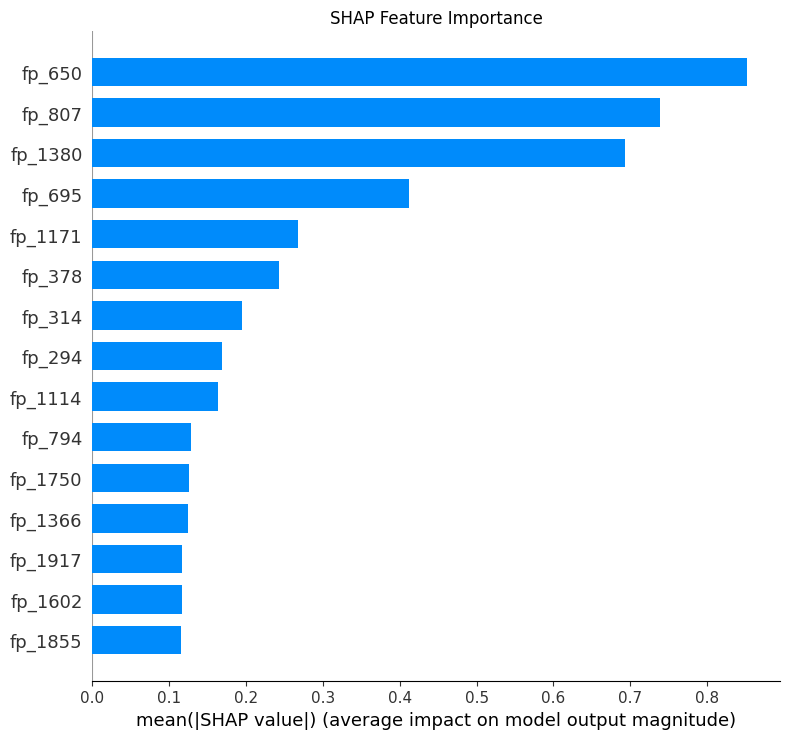

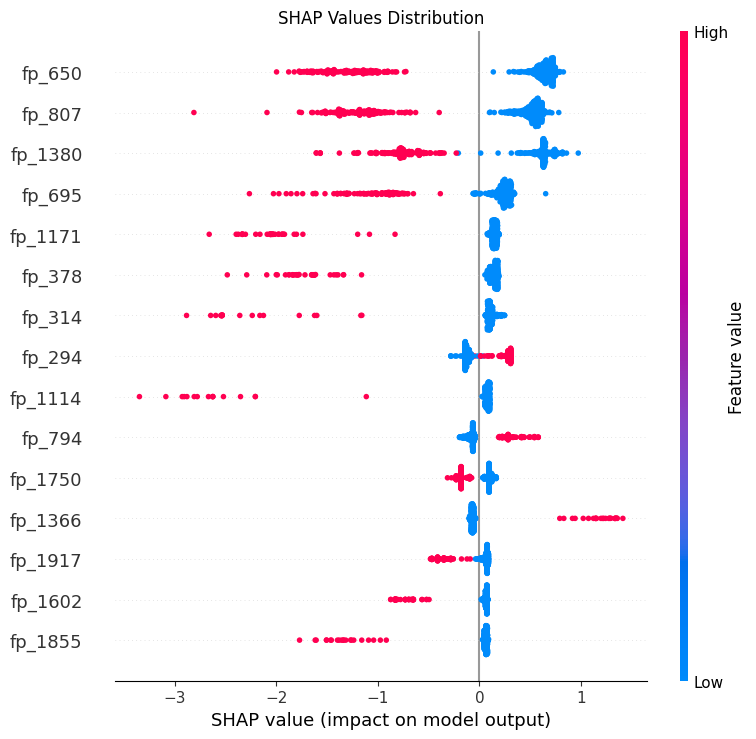

In [10]:
# Create explainer
xgb_explainer = shap.TreeExplainer(xgb_reg)

# Calculate SHAP values
xgb_explainer_values = xgb_explainer.shap_values(X_train)


create_shap(xgb_explainer_values, X_train, 15)


# Save SHAP values for later use
shap_df = pd.DataFrame(
    xgb_explainer_values,
    columns=X_train.columns
)

## Check SHAP plots of RFRegressor

In [4]:
from sklearn.ensemble import RandomForestRegressor

best_rfr_params = {'n_estimators': 1000, 'max_depth': 46, 'max_features': 'sqrt'}
rfr_model = RandomForestRegressor(random_state=42, n_jobs=8, **best_rfr_params)
rfr_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=46, max_features='sqrt', n_estimators=1000,
                      n_jobs=8, random_state=42)

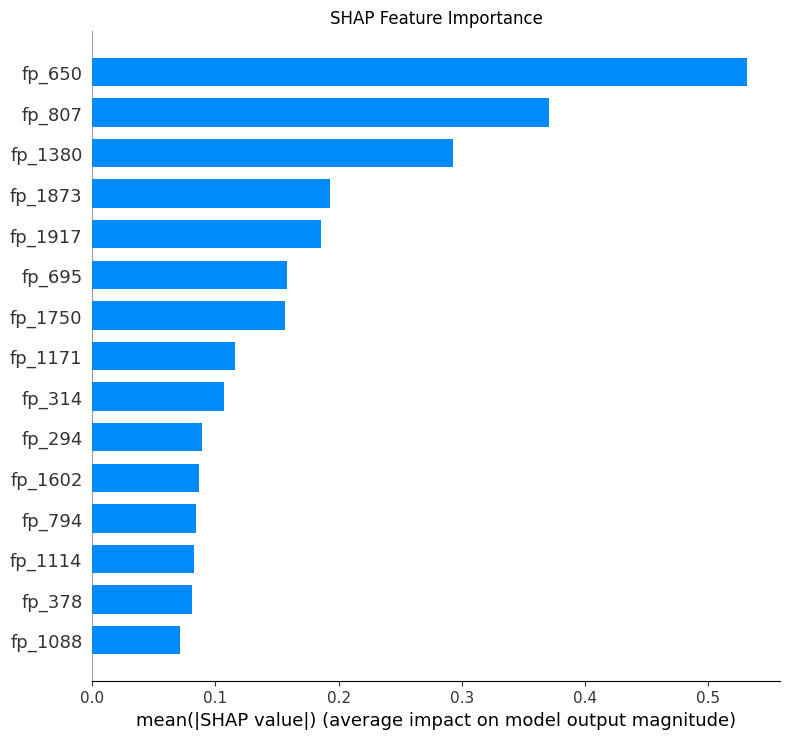

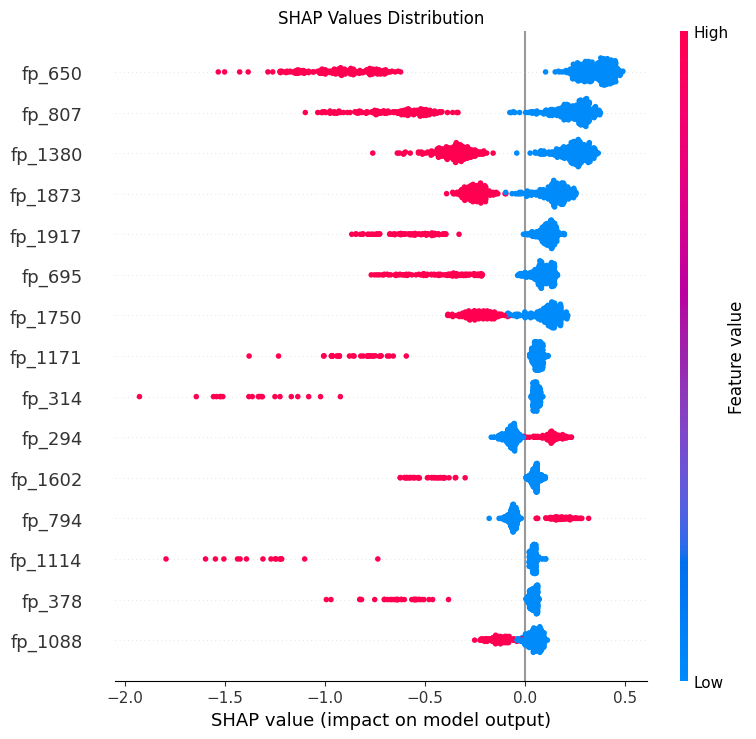

In [5]:
# Create explainer
tree_explainer = shap.TreeExplainer(rfr_model)

# Calculate SHAP values
tree_explainer_values = tree_explainer.shap_values(X_train)

# plot SHAP
create_shap(tree_explainer_values, X_train, 15)

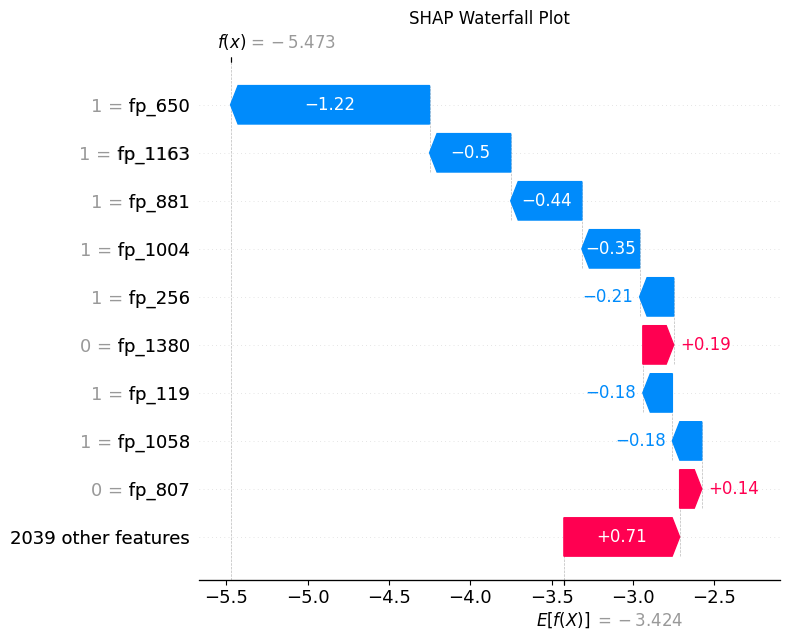

In [45]:
# For a single instance (e.g., first row)
row = 25
# Waterfall plot
plt.figure(figsize=(10, 6))
shap.plots.waterfall(
    shap.Explanation(
        values=tree_explainer_values[row],  # SHAP values for single instance
        base_values=tree_explainer.expected_value,  # base (average) value
        data=X_train.iloc[row],  # feature values
        feature_names=X_train.columns  # feature names
    ),
    show=False
)
plt.title("SHAP Waterfall Plot")
plt.tight_layout()
plt.show()

In [6]:
# Save SHAP values for later use
shap_rfr_df = pd.DataFrame(
    tree_explainer_values,
    columns=X_train.columns
)

In [88]:
import numpy as np

# Method 1: Using shap.summary_plot
shap_values = tree_explainer_values
feature_importance = np.abs(shap_values).mean(0)
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})
top_10_features = feature_importance_df.sort_values('importance', ascending=False).head(10)
top_10_features_list = list(top_10_features.index)

## Check fps

In [17]:
from rdkit import Chem
from rdkit.Chem import AllChem

def get_morganfp_df(data,
                    smiles_col='smiles',
                    label_col='label',
                    radius = 2,
                    ) -> pd.DataFrame:
    """
    Funtion to calculate MorganFPs and return them as DF
    """
    # Use SMILES as index in df
    data_temp = data.set_index(smiles_col)

    # Temp dictionary to store data
    temp_dict = {}
    
    # List of SMILES fialed to convert to MOL
    failed_smiles = []

    # Set up fingerptint generator
    fpgen = AllChem.GetMorganGenerator(radius=radius)

    for smile in data_temp.index:
        temp_mol = Chem.MolFromSmiles(smile)
        if temp_mol:
            # Set up additional output to store bit info
            ao = AllChem.AdditionalOutput()
            ao.CollectBitInfoMap()
            fps = fpgen.GetFingerprint(temp_mol, additionalOutput=ao)
        else:
            failed_smiles.append(smile)
        
        temp_dict[smile] = {'morganfp':fps,
                            'bitinfo': ao.GetBitInfoMap(),
                            'mol': temp_mol,
                            'label': data_temp.loc[smile, label_col]}
    
    morganfp_df = pd.DataFrame.from_dict(temp_dict, orient='index')

    if len(failed_smiles) > 0:
        print(f'Warning: {len(failed_smiles)} SMILES failed to convert to mol')
    
    return morganfp_df

morganfp_train = get_morganfp_df(train_df, label_col='label')
morganfp_train.head()


,morganfp,bitinfo,mol,label
CN(C)C(=O)c1ccc(cc1)OC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{322: ((8, 1),), 587: ((5, 2),), 650: ((4, 0),...",<rdkit.Chem.rdchem.Mol object at 0x7f1aca400900>,-9.625
CC(C)C=C,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{1: ((1, 0),), 66: ((1, 2),), 283: ((0, 1), (2...",<rdkit.Chem.rdchem.Mol object at 0x7f1aca4009e0>,2.452
CCc1cnccn1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{80: ((1, 0),), 294: ((0, 1),), 378: ((4, 0), ...",<rdkit.Chem.rdchem.Mol object at 0x7f1aca400ac0>,-5.809
CCCCCCCO,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{80: ((1, 0), (2, 0), (3, 0), (4, 0), (5, 0), ...",<rdkit.Chem.rdchem.Mol object at 0x7f1aca400dd0>,-2.917
Cc1cc(cc(c1)O)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{167: ((5, 2),), 613: ((4, 2), (6, 2)), 745: (...",<rdkit.Chem.rdchem.Mol object at 0x7f1aca400eb0>,-5.444


In [92]:
top_10_features_list

[650, 807, 1380, 1873, 1917, 695, 1750, 1171, 314, 294]

In [100]:
example_mols = {}

for feature in top_10_features_list:
    for i, index in enumerate(morganfp_train.index):
        if feature in morganfp_train.loc[index, 'bitinfo']:
            example_mols[feature] = i
            break
example_mols

{650: 0,
 807: 0,
 1380: 0,
 1873: 0,
 1917: 0,
 695: 0,
 1750: 0,
 1171: 40,
 314: 54,
 294: 2}

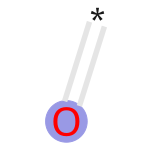

AttributeError: 'SVG' object has no attribute 'save'

In [113]:
from rdkit.Chem import Draw

for bit, row in example_mols.items():

    test_mol = Chem.MolFromSmiles(morganfp_train.index[row])
    bit_info = morganfp_train.iloc[row,1]

    mfp_svg = Draw.DrawMorganBit(test_mol, bit, bit_info, useSVG=True)
    display(mfp_svg)
    with open(f"../plots/bits/bit_{bit}.svg", "w") as file:
        file.write(mfp_svg)

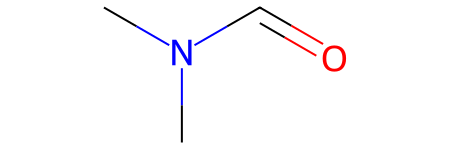

In [74]:
Chem.MolFromSmiles(morganfp_train.index[25])